<div align="center">

---
---
# 📚 Proyecto Final Programa Experto Data Science 06
---
---
#### Datamecum
#### Autor: Carlos Zamora

</div>

## Objetivo del proyecto

🎯 La naturaleza de la problemática presentada es de Regresión (Aprendizaje Supervisado). El objetivo principal es la obtención de un modelo que se ajuste a los datos proporcionados, y tenga buena capacidad de predicción.

---
## 📊 Fase 1: EDA

💡Dado que los datos están ofuscados, se descarta aplicar conocimiento de dominio a los mismos.

🔍 Comenzamos calculando los estadísticos básicos del dataset y graficando las entidades importantes (relaciones entre variables, distribuciones, etc.)

---

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from ipywidgets import interact, fixed
import missingno as msno

import sys
sys.path.append('..\src')
from functions import (unique_col_values, 
                           test_anderson_norm, 
                           heatmap_corr,
                           reset_test,
                           grafico_caja
                           )

In [2]:
datos = pd.read_excel('../data/train.xlsx')
datos.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,deseada
0,27585.8881,0.00,2.215558,176.46,4.49,1058.6,780.09,28.0,-1.867265,0.900023,21.539230
1,45693.3376,98.06,1.406881,NaN,6.65,1066.0,785.52,NaN,0.633919,0.862797,17.836744
2,110889.0000,0.00,0.000000,192.00,NaN,931.2,842.60,7.0,-0.203045,0.461557,23.404952
3,241081.0000,26.00,2.093422,210.00,3.93,882.0,699.00,28.0,-1.382800,0.338268,55.551081
4,34670.4400,124.10,0.000000,185.70,0.00,1083.4,NaN,28.0,-0.510016,0.603488,17.596806


In [3]:
datos.info()
datos.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772 entries, 0 to 771
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   x1       706 non-null    float64
 1   x2       685 non-null    float64
 2   x3       703 non-null    float64
 3   x4       690 non-null    float64
 4   x5       698 non-null    float64
 5   x6       704 non-null    float64
 6   x7       699 non-null    float64
 7   x8       687 non-null    float64
 8   x9       694 non-null    float64
 9   x10      680 non-null    float64
 10  deseada  772 non-null    float64
dtypes: float64(11)
memory usage: 66.5 KB


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,deseada
count,706.000000,685.000000,703.000000,690.000000,698.000000,704.000000,699.000000,687.000000,694.000000,680.000000,772.000000
mean,92761.097733,72.037898,0.882659,181.944594,6.168636,971.787997,772.917167,45.914119,0.018116,0.496178,35.895710
std,68338.519818,86.135309,1.026148,21.474526,6.033556,79.482087,81.459988,62.163402,0.979987,0.287545,16.786940
min,10404.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,-3.241267,0.005230,2.331808
25%,37900.302400,0.000000,0.000000,164.925000,0.000000,932.000000,725.950000,14.000000,-0.651777,0.248967,23.742796
50%,76729.000000,20.000000,0.000000,185.700000,6.000000,967.040000,779.700000,28.000000,0.046709,0.497494,34.222141
75%,131478.760000,141.300000,2.073865,192.000000,10.100000,1034.250000,824.000000,56.000000,0.654966,0.731890,45.865322
max,291600.000000,359.400000,2.292256,247.000000,32.200000,1145.000000,992.600000,365.000000,2.720169,0.998348,82.599225


In [4]:
unique_col_values(datos)

x1 | 244 | float64
x2 | 156 | float64
x3 | 125 | float64
x4 | 179 | float64
x5 | 141 | float64
x6 | 245 | float64
x7 | 261 | float64
x8 | 15 | float64
x9 | 695 | float64
x10 | 681 | float64
deseada | 714 | float64


In [5]:
datos['x8'].value_counts().sort_index()

x8
1.0        1
3.0       89
7.0       81
14.0      37
28.0     288
56.0      60
90.0      38
91.0      16
100.0     35
120.0      3
180.0     19
270.0      7
360.0      5
365.0      8
Name: count, dtype: int64

---
Con este primer vistazo a los datos, podemos aseverar varios puntos:
1. Hay una **variable extremadamente sesgada ("x1")**, con una diferencia muy grande en valor entre media y mediana; esto representa potencial incidencia de no normalidad. Además, tiene una distribución muy amplia (mucha distancia entre cuantiles); esto refleja la posible existencia de valores atípicos.
2. Dos variables **("x2" y "x3")** presentan **indicios de una distribución bimodal**, por la distribución de sus cuartiles. Podría indicar que datos proceden de 2 distribuciones distintas para cada una.
3. **"x10"** parece ser una variable de tipo porcentaje, como un **coeficiente o un ratio**.
4. **"x8"** presenta solamente **15 valores distintos**. Además, estos 15 valores parecen ser días del año, ya que el rango va desde 1 a 365. Podría ser un indicador de la sucesión de un evento.
5. Presencia de **nulos en todas las variables excepto en la "deseada"**.
---

<Axes: >

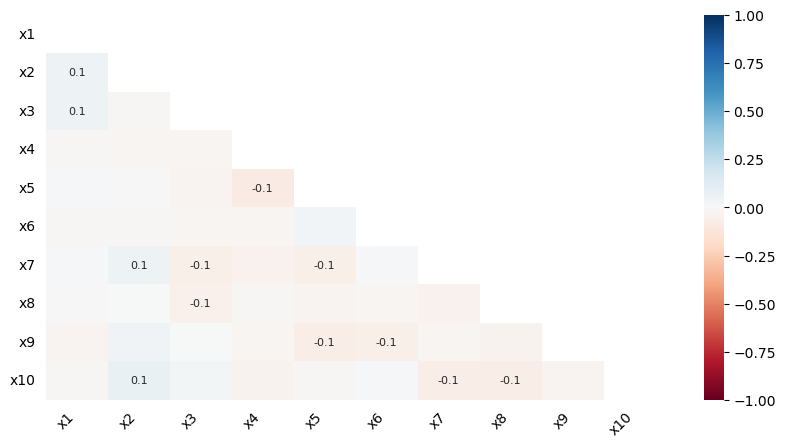

In [6]:
msno.heatmap(datos, figsize=(10,5), fontsize=10)

<Axes: >

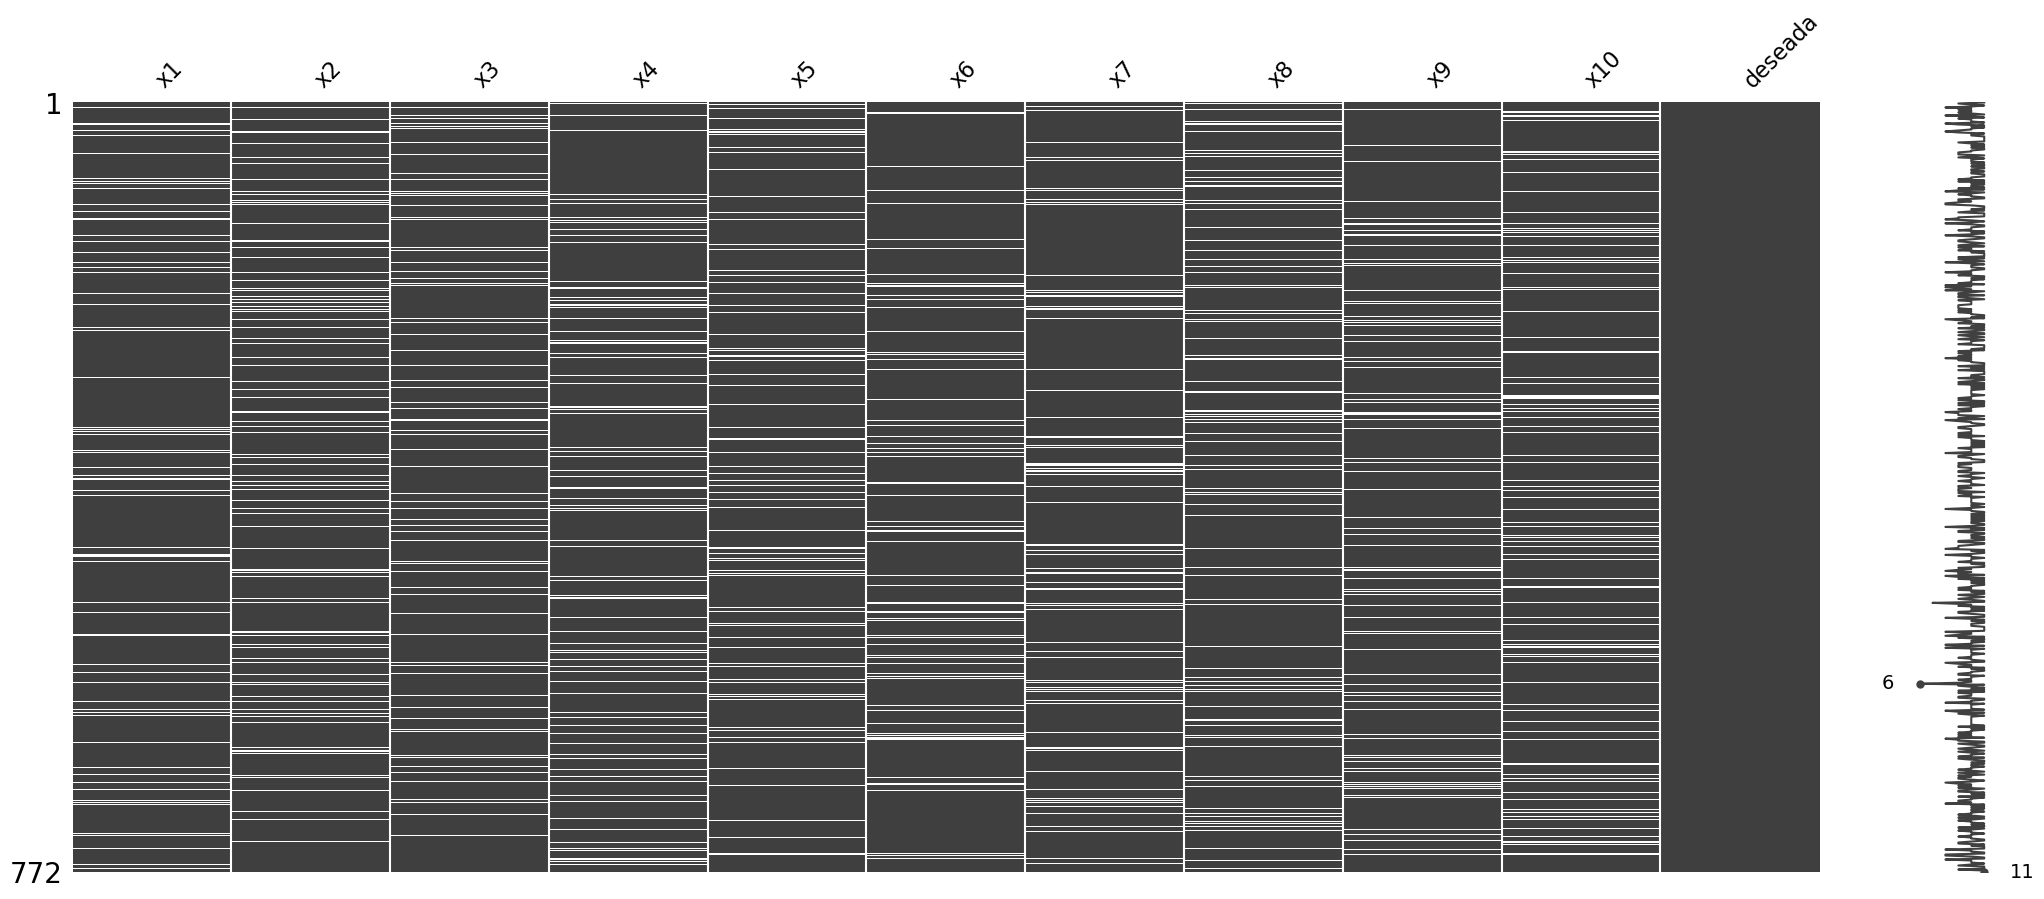

In [7]:
msno.matrix(datos)

---
El análisis de nulos en detalle revela que el proceso que explica los datos faltantes podría ser **MCAR o MAR**. El MCAR es más una idealización teórica que un factor explicativo de datos faltantes en un contexto real, por tanto asumimos que existe un proceso [(Missing at Random)](https://stefvanbuuren.name/fimd/sec-MCAR.html) que los explica, y **sería correcto aplicar técnicas de imputación**.

---

Text(0.5, 1.02, 'Relaciones entre variables y distribución (para agrandar,hacer clic en la imagen)')

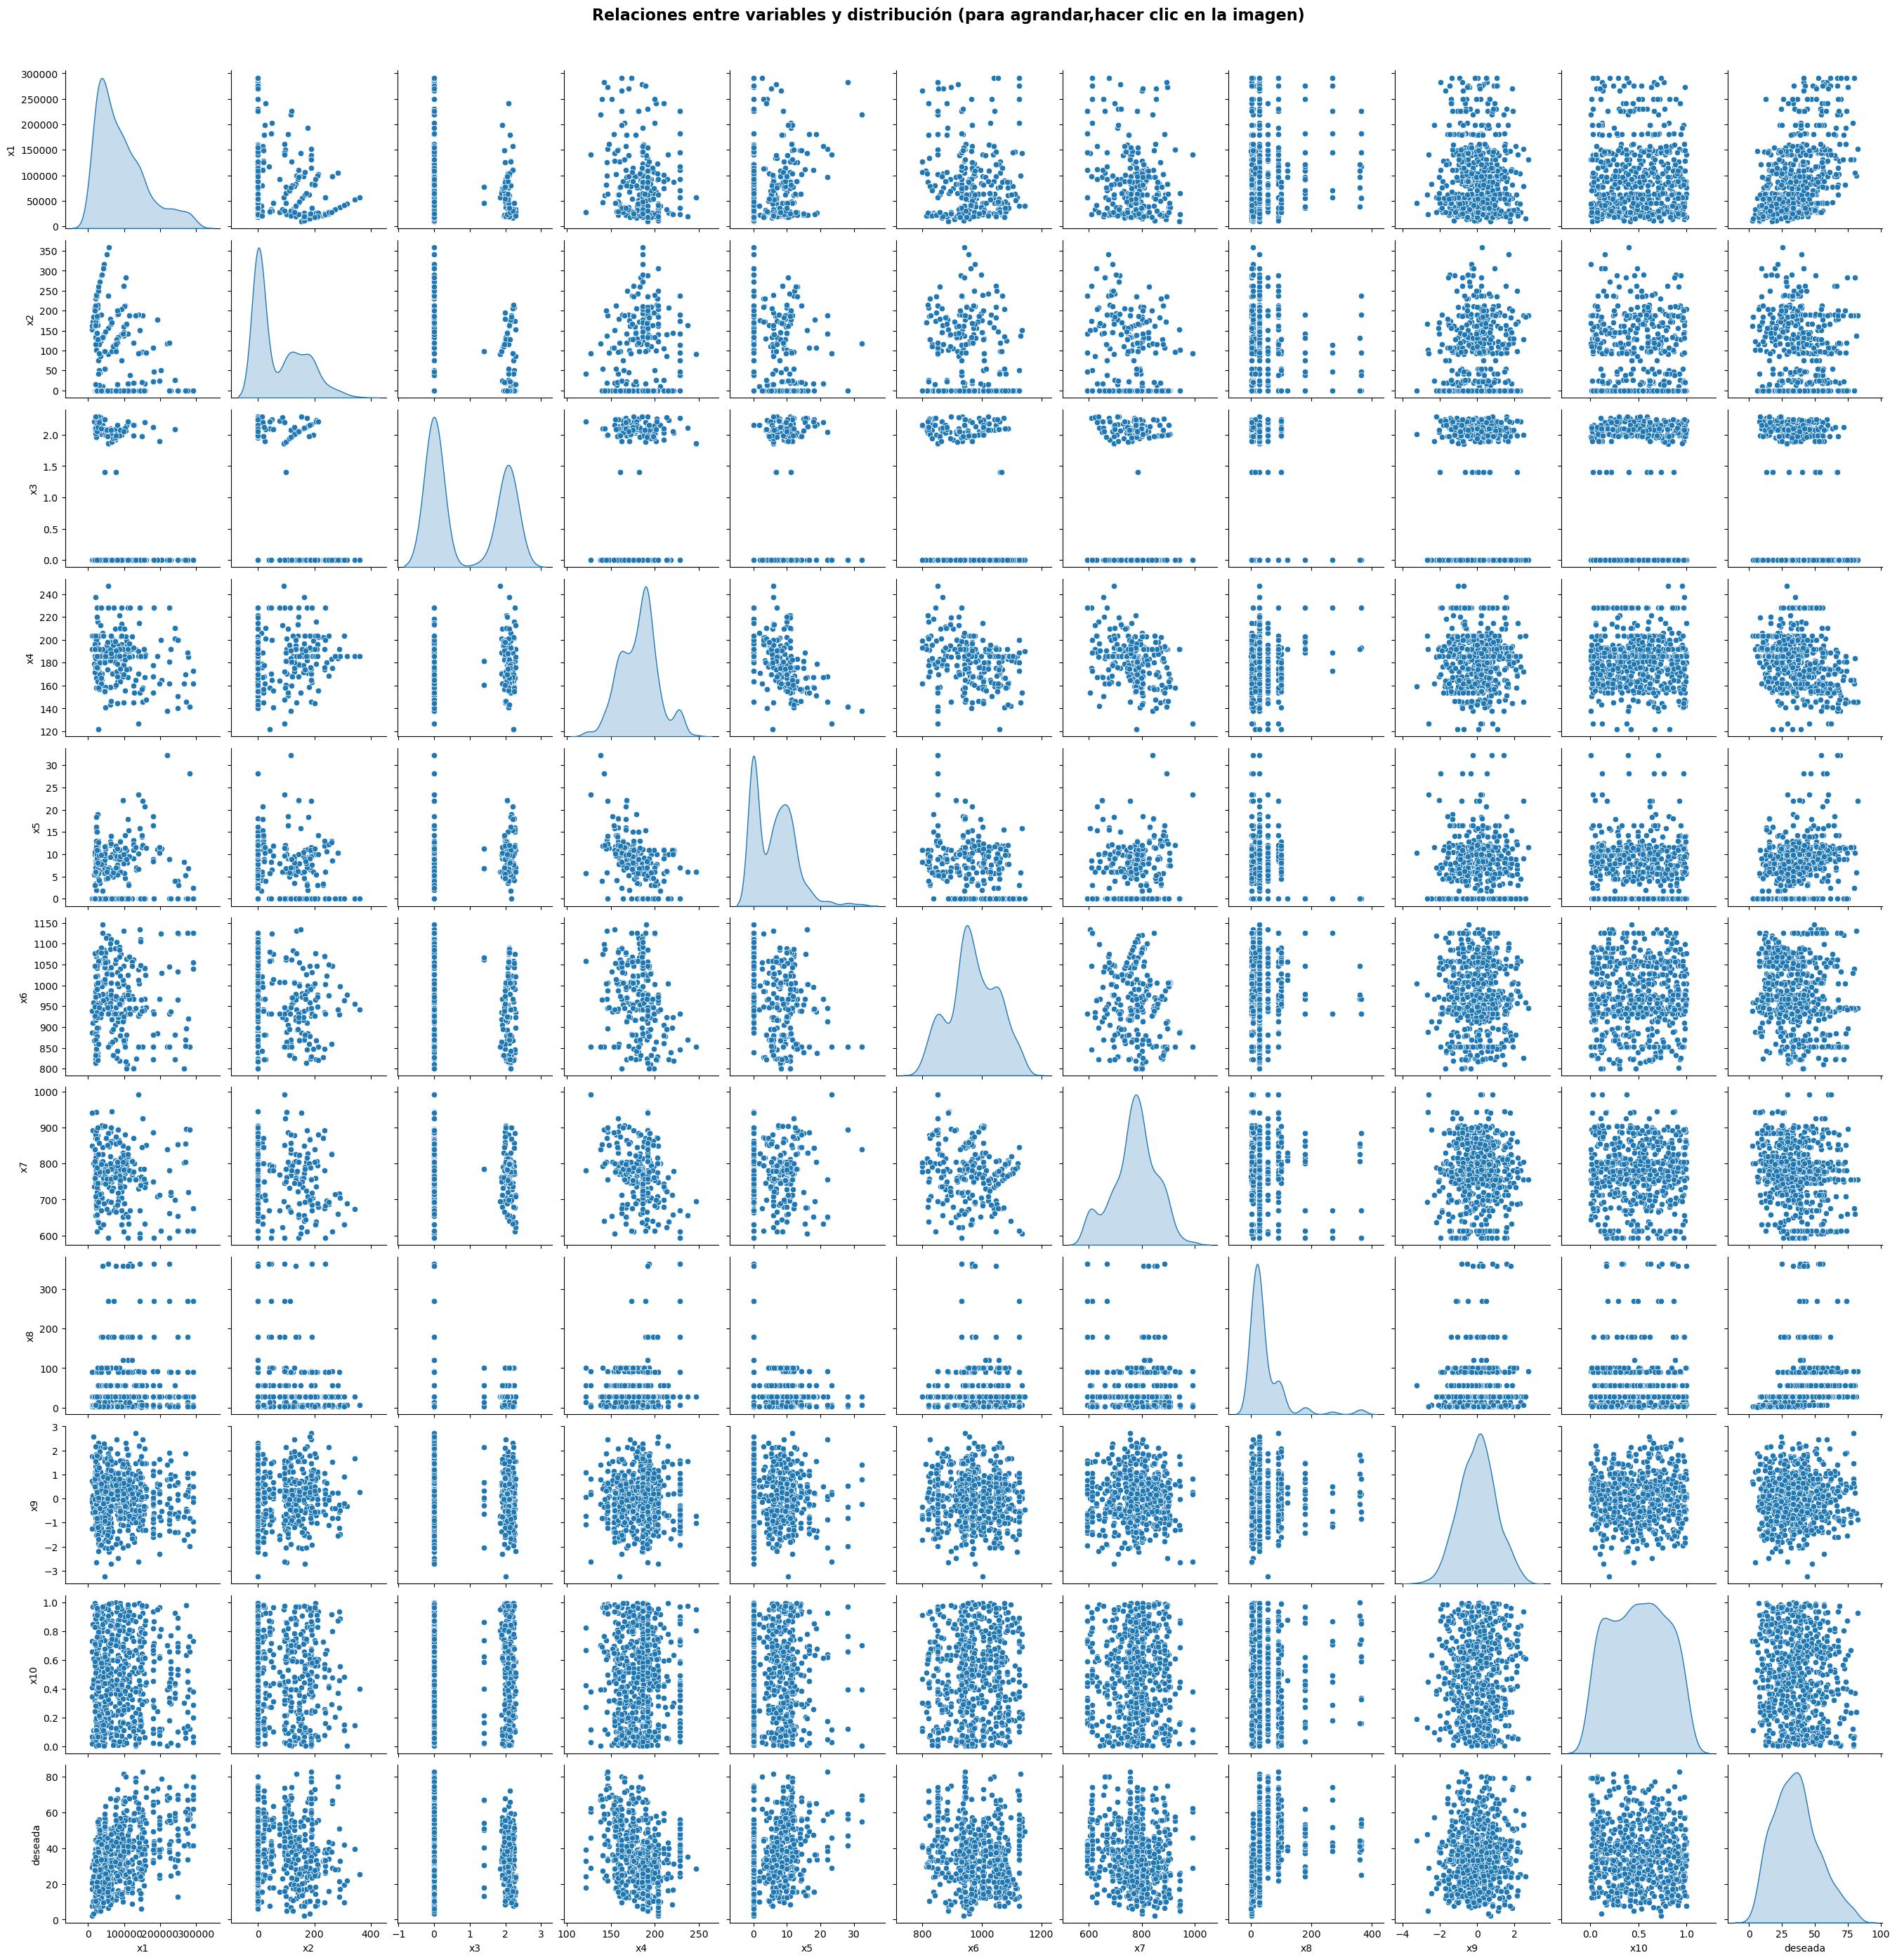

In [8]:
bplot = sns.pairplot(datos, height=2.5, diag_kind='kde')
bplot.fig.suptitle("Relaciones entre variables y distribución (para agrandar,\
hacer clic en la imagen)", fontsize=16, fontweight='bold', y=1.02)

---
De la parrilla anterior pueden extraerse varios **insights adicionales**:
1. La **distribución** de las variables es, en general, no normal, a excepción de algunas ("x9").
2. La **dispersión** solo muestra una relación más o menos clara entre las variables independientes "x4" y "x5". Además, dicha relación parece ser de carácter polinómico. El resto de nubes de puntos no siguen ningún patrón estilizado.
3. En cuanto a las **distribuciones bimodales** que parecían intuirse mediante estadísticos relevantes, la única que se sostiene parece ser la variable "x3", que tiene una dualidad muy marcada.

---

In [9]:
dict_anderson = test_anderson_norm(datos)
df_anderson = pd.DataFrame.from_dict(dict_anderson, orient='index')
df_anderson.head(10)

,statistic,critical_values,significance_level
x1,23.257083,"[0.573, 0.652, 0.783, 0.913, 1.086]","[15.0, 10.0, 5.0, 2.5, 1.0]"
x2,55.885764,"[0.573, 0.652, 0.782, 0.913, 1.086]","[15.0, 10.0, 5.0, 2.5, 1.0]"
x3,114.072268,"[0.573, 0.652, 0.783, 0.913, 1.086]","[15.0, 10.0, 5.0, 2.5, 1.0]"
x4,4.908804,"[0.573, 0.652, 0.783, 0.913, 1.086]","[15.0, 10.0, 5.0, 2.5, 1.0]"
x5,26.509100,"[0.573, 0.652, 0.783, 0.913, 1.086]","[15.0, 10.0, 5.0, 2.5, 1.0]"
x6,3.740565,"[0.573, 0.652, 0.783, 0.913, 1.086]","[15.0, 10.0, 5.0, 2.5, 1.0]"
x7,4.446621,"[0.573, 0.652, 0.783, 0.913, 1.086]","[15.0, 10.0, 5.0, 2.5, 1.0]"
x8,83.103209,"[0.573, 0.652, 0.782, 0.913, 1.086]","[15.0, 10.0, 5.0, 2.5, 1.0]"
x9,0.287057,"[0.573, 0.652, 0.783, 0.913, 1.086]","[15.0, 10.0, 5.0, 2.5, 1.0]"
x10,6.623299,"[0.573, 0.652, 0.782, 0.913, 1.086]","[15.0, 10.0, 5.0, 2.5, 1.0]"


---
Si comparamos el estadístico que devuelve el test con los valores críticos para los distintos niveles de significatividad, comprobamos que, **exceptuando la variable "x9", se rechaza la hipótesis nula de normalidad** a todos los niveles de significancia.

---

In [10]:
interact(
   heatmap_corr,
   df=fixed(datos),
   metodologia=['spearman', 'pearson']
)

interactive(children=(Dropdown(description='metodologia', options=('spearman', 'pearson'), value='spearman'), …

<function data_analysis.heatmap_corr(df, metodologia)>

---
Utilizando el método de rangos de Spearman, robusto a no normalidad, vemos que existe **correlación fuerte entre "x4" y "x5", y entre "x8" y la "deseada"**.

La existencia de alta correlación entre la variable regresada y una regresora no es problemático de cara a realizar predicciones. Sin embargo, si en la fase del modelado optásemos por uno de regresión lineal, habrá que considerar la posible multicolinealidad derivada de la correlación entre "x4" y "x5".

---

In [11]:
# Dado que en nuestros datos existen indicios de relaciones no lineales entre
# variables, vamos a aplicar el test RESET de Ramsey para corroborarlo
y = "deseada"
X = list(datos.drop(columns="deseada").columns)

In [12]:
interact(
   reset_test,
   df=fixed(datos),
   X=fixed(X),
   y=fixed(y),
   potencia=range(2,10)
)

interactive(children=(Dropdown(description='potencia', options=(2, 3, 4, 5, 6, 7, 8, 9), value=2), Output()), …

<function data_analysis.reset_test(df, X, y, potencia)>

---
Se ha detectado la **presencia de relaciones** polinómicas de **hasta cuarto orden**

---

In [13]:
interact(
   grafico_caja,
   df=fixed(datos),
   column=datos.columns.tolist()
)

interactive(children=(Dropdown(description='column', options=('x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', …

<function data_analysis.grafico_caja(df, column)>

---
A **excepción de "x3", "x6" y "x10", todas las variables presentan valores atípicos**.

---

---
## 📝 Conclusiones principales EDA

- Todas las variables excepto la regresada presentan **nulos, siguiendo patrón MAR** --> se puede aplicar imputación para su subsanación
- Alta presencia de **no normalidad** --> problemas en modelos de reg. lineal por violación de supuestos Gauss-Markov si la no-normalidad se traslada a los errores
- Variable **x8** potencialmente categórica (15 valores únicos sobre 772 registros). Variable **x1** candidata a aplicarle *binnization* debido a la amplitud de su distribución y los saltos discretos que se aprecian entre quintiles.
- **Correlaciones** en el umbral problemático para las variables "x4" y "x5" --> a vigilar si se elige un modelo de reg. lineal por posible multicolinealidad
- Presencia de **relaciones polinómicas** entre las X y la y (hasta de grado 4) --> a tener en cuenta si se elige un modelo lineal para predecir
- **Outliers** en casi todos los atributos --> problemas en modelos de reg. lineal por inflación de varianza, que hace que las β dejen de ser MELI. En otro tipo de modelos, como los basados en árboles, no es tan problemático, pero aún así se aplicará escalado robusto en la fase posterior.
---

---
Para finalizar con la fase de EDA, se va a proceder a agrupar la variable 'x1' en *bins*, debido a los hallazgos durante la fase exploratoria.

Se va a optar por agrupar la variable en cuartiles, buscando un compromiso entre generalidad y granularidad, y sobre todo poniendo énfasis en no sobreajustar la distribución más adelante en la fase de modelizado.

---

In [ ]:
datos['x1_bin'] = pd.qcut(x=datos['x1'], q=4, labels=False, duplicates='drop')
df_pipeline = datos.drop(columns='x1')
df_pipeline.to_csv('df_pipeline.csv')